### Performance of reduced shear estimation per magnitude bin of RRG and CNN estimators

In [ ]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser

from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_spec, print_spec
from wlenet.dataset.io import load_sim, load_target
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps
from wlenet.models.figures import show_scatter_label_pred, show_first_conv_kernels
from wlenet.models.predict import predict, predict_test_time_aug
from wlenet.dataset.normalization import norm_mean_std

In [2]:
test_sets = ['clash_003_test']
mag_auto_edges = np.array([17, 20.5, 21.5, 22.5, 23.5, 25.5])
num_batches = 2000
save_figures = True

In [3]:
from wlenet.reduction.stamps import half_light_radii, chi_shapes, rrg_shapes


def model_performance(x_seq_test, y_seq_test, model):
    
    y_seq_ptta = predict_test_time_aug(norm_mean_std(x_seq_test), model)
    y_seq_ptta, calib_ptta, rmse_ptta = step_bias_calib(y_seq_test, y_seq_ptta, verbose=False)
    
    return rmse_ptta


def rrg_performance(x_seq_test, y_seq_test, max_radius=10, num_trials=60):
    
    psf_radius = (0.12 / 0.065) / 2.355    
    radii = half_light_radii(x_seq_test)
    y_rrg = rrg_shapes(x_seq_test, radii, psf_radius)
    inds = np.all(np.abs(y_rrg) < 1.0, axis=1)
    _, _, rmse = step_bias_calib(y_seq_test[inds, :], y_rrg[inds, :], verbose=False)

    return rmse

In [4]:
def test_model_and_rrg(model_name):
    
    model_spec = load_spec(model_name)
    model = load_model(model_spec, load_weights=True, show_summary=False)

    noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
    noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
    post_sim = model_spec['kwargs_dataset']['post_sim']
    output_dim = get_output_dim(model)

    test_model_rmse = np.zeros((len(mag_auto_edges) - 1, 2))
    test_rrg_rmse = np.zeros((len(mag_auto_edges) - 1, 2))

    for i in range(len(mag_auto_edges) - 1):

        post_sim['mag_auto_min'] = mag_auto_edges[i]
        post_sim['mag_auto_max'] = mag_auto_edges[i+1]

        source_test = dict(zip(('x', 'y'), load_sim(test_sets, 'test', output_dim, post_sim=post_sim)))
        seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, norm_func=None)

        x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq_test, num_batches)

        test_model_rmse[i, :] = model_performance(x_seq_test, y_seq_test, model)
        test_rrg_rmse[i, :] = rrg_performance(x_seq_test, y_seq_test)    

        print(source_test['x'].shape[0])
        print(test_model_rmse[i, :])
        print(test_rrg_rmse[i, :])

    return test_model_rmse, test_rrg_rmse

In [5]:
test_model_rmse_0250, test_rrg_rmse_0250 = test_model_and_rrg('cnn_image_clash_uniform_mse_lsq_noise_0.250')
test_model_rmse_0500, test_rrg_rmse_0500 = test_model_and_rrg('cnn_image_clash_uniform_mse_lsq_noise_0.500')
test_model_rmse_1000, test_rrg_rmse_1000 = test_model_and_rrg('cnn_image_clash_uniform_mse_lsq')

16726
[0.14993623 0.15524229]
[0.21961838 0.22343614]
37053
[0.18961741 0.18945862]
[0.23822281 0.24286602]
90119
[0.20085418 0.20045874]
[0.24732306 0.24445544]
113162
[0.22327224 0.22729555]
[0.25101102 0.25390473]
50926
[0.25746055 0.25883224]
[0.25911962 0.25834653]
16726
[0.15338207 0.15917089]
[0.21962733 0.22347146]
37053
[0.19444713 0.19555845]
[0.23832724 0.24306853]
90119
[0.20821592 0.2080038 ]
[0.24811805 0.24525126]
113162
[0.23043812 0.23385114]
[0.25225049 0.25507036]
50926
[0.26122384 0.26192593]
[0.26548292 0.26471693]
16726
[0.15298801 0.1572291 ]
[0.21972048 0.22356834]
37053
[0.19766821 0.19798327]
[0.23907194 0.24384033]
90119
[0.21317239 0.21116666]
[0.25009929 0.2472939 ]
113162
[0.2397302  0.24297863]
[0.25748027 0.26036891]
50926
[0.2768462  0.27892353]
[0.28958071 0.29143995]


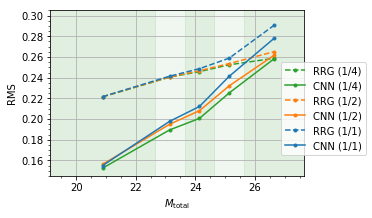

In [6]:
mag_auto_centers = (mag_auto_edges[1:] + mag_auto_edges[:-1]) / 2
cosmos_to_clash_delta_m = 2.1391725988718227

plt.rcParams['figure.figsize'] = (5.25,3.15)
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$M_{\mathrm{total}}$')
ax1.set_ylabel('RMS')

ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_rrg_rmse_0250, 1), '.--', color='C2', label='RRG (1/4)')
ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_model_rmse_0250, 1), '.-', color='C2', label='CNN (1/4)')

ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_rrg_rmse_0500, 1), '.--', color='C1', label='RRG (1/2)')
ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_model_rmse_0500, 1), '.-', color='C1', label='CNN (1/2)')

ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_rrg_rmse_1000, 1), '.--', color='C0', label='RRG (1/1)')
ax1.plot(mag_auto_centers + cosmos_to_clash_delta_m, np.mean(test_model_rmse_1000, 1), '.-', color='C0', label='CNN (1/1)')

plt.xlim(np.array([mag_auto_edges[0] + cosmos_to_clash_delta_m, mag_auto_edges[-1] + cosmos_to_clash_delta_m]))
plt.ylim([0.145, 0.305])
plt.grid('on')

for i in range(len(mag_auto_edges) - 1):
    alpha = [0.12, 0.06][i % 2]
    ax1.axvspan(mag_auto_edges[i] + cosmos_to_clash_delta_m, mag_auto_edges[i+1] + cosmos_to_clash_delta_m, 
                alpha=alpha, color='green', linewidth=0.5)
ax1.minorticks_on()
#ax1.legend(loc='upper left')
ax1.legend(loc='bottom right', bbox_to_anchor=(0.89,0.72))
plt.gcf().subplots_adjust(bottom=0.15, left=0.15, right=0.82)
#plt.tight_layout()

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/performance/performance_per_mag_lower_noise.pdf')
    plt.savefig(fig_path)